In [1]:
import os
import glob
import pickle

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cores = '14'

BASE_DIR     = f"../../data/MAR2_al/MAR2_prbs_random/{cores}"   # point this at the “14” folder
IDLE_POWER   = 2.51                                  # watts, per core
ASSUMED_PMAX = 2.83                                 # watts, per core at max‐freq
DATA_DIR     = f"../../results/{cores}/"

In [3]:
def load_round_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def compute_power_proxy(pkl):
    """
    Use the built-in freq_aperf_mperf_core ratio as utilization.
    P_core = idle + (Pmax - idle) * util
    """
    util = pkl["freq_aperf_mperf_core"].astype(float)
    return IDLE_POWER + (ASSUMED_PMAX - IDLE_POWER) * util

def ensure_timedelta_index(df):
    """
    If the index isn't already a DatetimeIndex or TimedeltaIndex,
    assume it's numeric seconds and convert to TimedeltaIndex.
    """
    idx = df.index
    if not isinstance(idx, (pd.DatetimeIndex, pd.TimedeltaIndex)):
        df = df.copy()
        df.index = pd.to_timedelta(idx.astype(float), unit="s")
    return df

def resample_df(df, freq="500ms"):
    """
    Resample to uniform freq (500 ms), taking the mean and interpolating.
    """
    df = ensure_timedelta_index(df)
    return df.resample(freq).mean().interpolate()

def process_round(pkl_path):
    pkl   = load_round_pickle(pkl_path)
    temp  = pkl["temp_core"]                   # timestamp × cores
    power = compute_power_proxy(pkl)           # same shape

    # resample
    t_rs = resample_df(temp)
    p_rs = resample_df(power)

    # rename for clarity
    t_rs.columns = [f"T_core_{c}" for c in t_rs.columns]
    p_rs.columns = [f"P_core_{c}" for c in p_rs.columns]

    return pd.concat([p_rs, t_rs], axis=1)

In [4]:
pattern = os.path.join(BASE_DIR, "round*", "preprocessing", "round*.pkl")
rounds  = sorted(glob.glob(pattern))
summary = []

for pkl_path in rounds:
    round_name = os.path.basename(os.path.dirname(os.path.dirname(pkl_path)))
    df         = process_round(pkl_path)

    pcols = [c for c in df if c.startswith("P_core_")]
    tcols = [c for c in df if c.startswith("T_core_")]

    summary.append({
        "round":      round_name,
        "mean_power": df[pcols].values.mean(),
        "max_power":  df[pcols].values.max(),
        "mean_temp":  df[tcols].values.mean(),
        "max_temp":   df[tcols].values.max(),
    })

# write out and print summary
summary_df = pd.DataFrame(summary).set_index("round").sort_index()
display(summary_df.round(2))

,mean_power,max_power,mean_temp,max_temp
round,,,,
round0,880.24,962.51,64.33,83.0
round1,880.40,962.51,62.06,83.0
round2,879.53,962.51,63.75,83.0
round3,880.40,962.51,64.54,83.0
round4,879.56,962.51,63.53,83.0


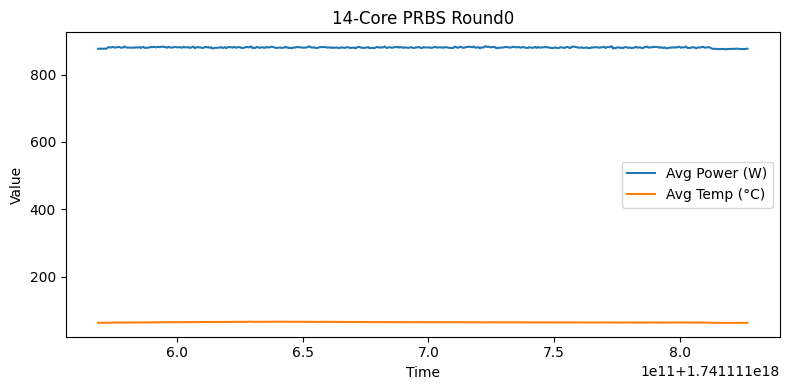

In [5]:
# quick visual for round0
if "round0" in summary_df.index:
    
    df0   = process_round(rounds[0])
    avg_p = df0[[c for c in df0 if c.startswith("P_core_")]].mean(axis=1)
    avg_t = df0[[c for c in df0 if c.startswith("T_core_")]].mean(axis=1)

    plt.figure(figsize=(8,4))
    plt.plot(avg_p.index, avg_p, label="Avg Power (W)")
    plt.plot(avg_t.index, avg_t, label="Avg Temp (°C)")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("14-Core PRBS Round0")
    plt.legend()
    plt.tight_layout()
    plt.show()